# Supervised Models

1) Decision Tree
2) Random Forest
3) K-NN
4) NB
5) SVM


In [3]:
#imports
import os
import psutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from typing import Dict, List, Tuple
from dataset.data import Dataset
from dataset.nfv2 import load_data
from numpy.typing import NDArray
keras = tf.keras

# Enable determinsim
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# CIC-IDS2017 DATASET

In [4]:
cicids: Tuple[Dataset, Dataset] = load_data("data/sampled/cicids_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore

cicids_train, cicids_test = cicids
#print(cicids_train.X, cicids_train.y)

In [5]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [6]:
corr_features = correlation(cicids_train.X, 0.9)
print(len(set(corr_features)))
corr_features

9


{'CLIENT_TCP_FLAGS',
 'DURATION_IN',
 'ICMP_IPV4_TYPE',
 'IN_PKTS',
 'MAX_IP_PKT_LEN',
 'MAX_TTL',
 'NUM_PKTS_1024_TO_1514_BYTES',
 'NUM_PKTS_UP_TO_128_BYTES',
 'OUT_PKTS'}

In [7]:
cicids_train.X.drop(corr_features,axis=1)
cicids_test.X.drop(corr_features,axis=1)

PROTOCOL  L7_PROTO  IN_BYTES     OUT_BYTES  TCP_FLAGS  \
58741   0.280702  0.000000  0.000002  6.845543e-07   0.000000   
857380  0.280702  0.000000  0.000003  4.829027e-07   0.000000   
31438   0.280702  0.021101  0.000002  5.147424e-07   0.000000   
713320  0.087719  0.000000  0.000111  1.135087e-05   1.000000   
300719  0.280702  0.000000  0.000002  6.208749e-07   0.000000   
...          ...       ...       ...           ...        ...   
861629  0.280702  0.020669  0.000003  5.306623e-07   0.000000   
773241  0.087719  0.000000  0.000088  1.015157e-05   0.134529   
722249  0.280702  0.000000  0.000003  1.268283e-06   0.000000   
523684  0.280702  0.000000  0.000002  0.000000e+00   0.000000   
12356   0.087719  0.028226  0.000021  3.714636e-06   0.982063   

        SERVER_TCP_FLAGS  FLOW_DURATION_MILLISECONDS  DURATION_OUT   MIN_TTL  \
58741           0.000000                         0.0           0.0  0.000000   
857380          0.000000                         0.0           0.0  0.501961   
31438           0.000000                         0.0           0.0  0.000000   
713320          0.421525                         0.0           0.0  0.384314   
300719          0.000000                         0.0           0.0  0.501961   
...                  ...                         ...           ...       ...   
861629          0.000000                         0.0           0.0  0.501961   
773241          0.116592                         0.0           0.0  0.415686   
722249          0.000000                         0.0           0.0  0.000000   
523684          0.000000                         0.0           0.0  0.000000   
12356           0.408072                         0.0           0.0  0.501961   

        LONGEST_FLOW_PKT  ...  NUM_PKTS_128_TO_256_BYTES  \
58741           0.001549  ...                   0.000527   
857380          0.000966  ...                   0.000000   
31438           0.001059  ...                   0.000000   
713320          0.018210  ...                   0.002633   
300719          0.001365  ...                   0.000000   
...                  ...  ...                        ...   
861629          0.001105  ...                   0.000000   
773241          0.018179  ...                   0.001053   
722249          0.003237  ...                   0.000527   
523684          0.000583  ...                   0.000000   
12356           0.007671  ...                   0.000527   

        NUM_PKTS_256_TO_512_BYTES  NUM_PKTS_512_TO_1024_BYTES  TCP_WIN_MAX_IN  \
58741                    0.000000                    0.000000        0.000000   
857380                   0.000000                    0.000000        0.000000   
31438                    0.000000                    0.000000        0.000000   
713320                   0.000958                    0.000473        0.125002   
300719                   0.000000                    0.000000        0.000000   
...                           ...                         ...             ...   
861629                   0.000000                    0.000000        0.000000   
773241                   0.000958                    0.000473        0.125002   
722249                   0.000000                    0.000000        0.000000   
523684                   0.000000                    0.000000        0.000000   
12356                    0.000000                    0.000473        0.125002   

        TCP_WIN_MAX_OUT  ICMP_TYPE  DNS_QUERY_ID  DNS_QUERY_TYPE  \
58741          0.000000        0.0      0.666850        0.109804   
857380         0.000000        0.0      0.245624        0.003922   
31438          0.000000        0.0      0.534539        0.109804   
713320         0.976577        0.0      0.000000        0.000000   
300719         0.000000        0.0      0.424659        0.003922   
...                 ...        ...           ...             ...   
861629         0.000000        0.0      0.813901        0.109804   
773241         0.976577     

## DECISION TREE

In [8]:
from sklearn import tree
def build_decision_tree():

    model = tree.DecisionTreeClassifier(criterion="log_loss")

    return model


In [9]:
cicids_decision_tree = build_decision_tree()
start = time()
#load1, load5, load15 = psutil.getloadavg()
cpu_usage = psutil.cpu_percent(interval= None)
cicids_history = cicids_decision_tree.fit(cicids_train.X, cicids_train.y)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage


inferences = cicids_decision_tree.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")


(200000,)
First 10 predictions:
[0 0 0 0 1 0 0 0 0 0]


True Negatives: 175257
False Positives: 867
False Negatives: 796
True Positives: 23080


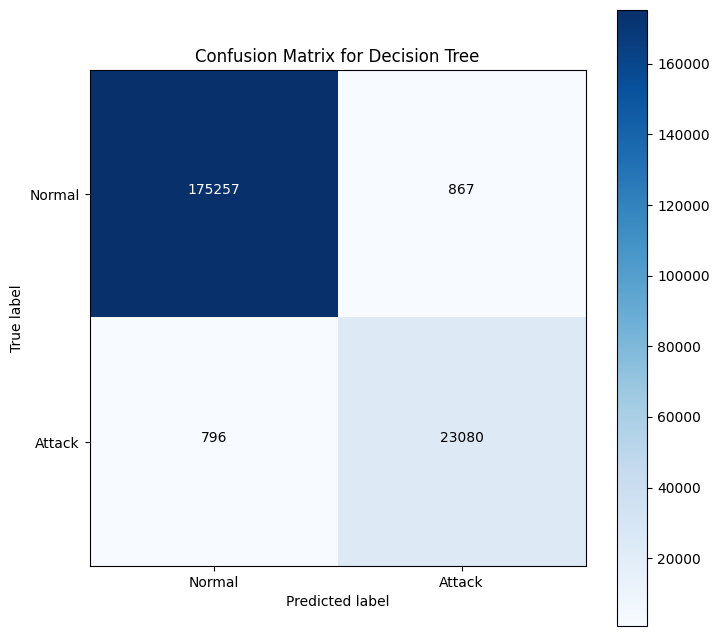

Using Decision Tree:
CIC-IDS Accuracy: 0.9917
CIC-IDS Precision: 0.9638
CIC-IDS Recall: 0.9667
CIC-IDS F1: 0.9652
CIC-IDS Miss Rate: 0.0333
CIC-IDS Training Time: 8.5389
CIC-IDS CPU Usage: 0.6000


In [10]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Decision Tree")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Decision Tree:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")


# Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
def build_random_forest():

    model = RandomForestClassifier(criterion="log_loss")

    return model

In [12]:
cicids_random_forest = build_random_forest()
start = time()
#load1, load5, load15 = psutil.getloadavg()
cpu_usage = psutil.cpu_percent(interval= None)
cicids_history = cicids_random_forest.fit(cicids_train.X, cicids_train.y)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage


inferences = cicids_random_forest.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

(200000,)
First 10 predictions:
[0 0 0 0 0 0 0 0 0 0]


True Negatives: 176040
False Positives: 84
False Negatives: 812
True Positives: 23064


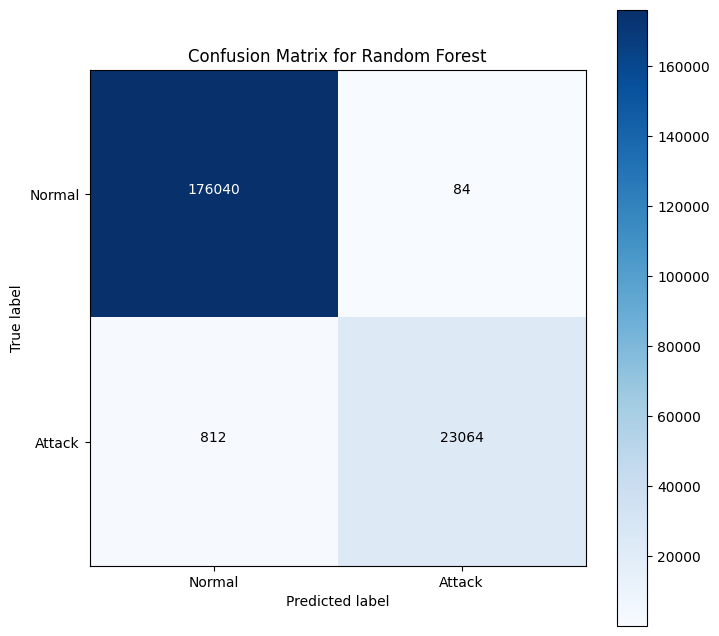

Using Random Forest:
CIC-IDS Accuracy: 0.9955
CIC-IDS Precision: 0.9964
CIC-IDS Recall: 0.9660
CIC-IDS F1: 0.9809
CIC-IDS Miss Rate: 0.0340
CIC-IDS Training Time: 128.9943
CIC-IDS CPU Usage: 0.2000


In [13]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Random Forest")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Random Forest:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

# K-NN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
def build_knn():

    model = KNeighborsClassifier(n_neighbors=5)

    return model

In [7]:
'''cicids_knn = build_knn()
start = time()
#load1, load5, load15 = psutil.getloadavg()
cpu_usage = psutil.cpu_percent(interval= None)
cicids_history = cicids_knn.fit(cicids_train.X, cicids_train.y)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage


inferences = cicids_knn.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")'''
try:
    # Code that might cause a crash
    cicids_knn = build_knn()
    start = time()
    cpu_usage = psutil.cpu_percent(interval=None)
    cicids_history = cicids_knn.fit(cicids_train.X, cicids_train.y)
    training_time_cicids = time() - start
    cpu_usage_cicids = cpu_usage

    inferences = cicids_knn.predict(cicids_test.X)
    print(inferences.shape)
    print(f"First 10 predictions:\n{inferences[:10]}")

except Exception as e:
    print("An error occurred:", str(e))

: 

: 

In [ ]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for K-NN")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using K-NN:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

# SVM

In [1]:
from sklearn.svm import SVC
def build_svm():

    model = SVC()

    return model

In [ ]:
cicids_svm = build_svm()
start = time()
#load1, load5, load15 = psutil.getloadavg()
cpu_usage = psutil.cpu_percent(interval= None)
cicids_history = cicids_svm.fit(cicids_train.X, cicids_train.y)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage


inferences = cicids_svm.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

In [ ]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for SVM")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using SVM:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

NB 

In [14]:
from sklearn.naive_bayes import GaussianNB
def build_NB():

    model = GaussianNB()

    return model

In [16]:
cicids_NB = build_NB()
start = time()
cpu_usage = psutil.cpu_percent(interval= None)
cicids_history = cicids_NB.fit(cicids_train.X, cicids_train.y)
training_time_cicids = time()-start 
cpu_usage_cicids = cpu_usage


inferences = cicids_NB.predict(cicids_test.X)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

(200000,)
First 10 predictions:
[0 0 0 0 0 0 0 0 0 0]


True Negatives: 125698
False Positives: 50426
False Negatives: 1222
True Positives: 22654


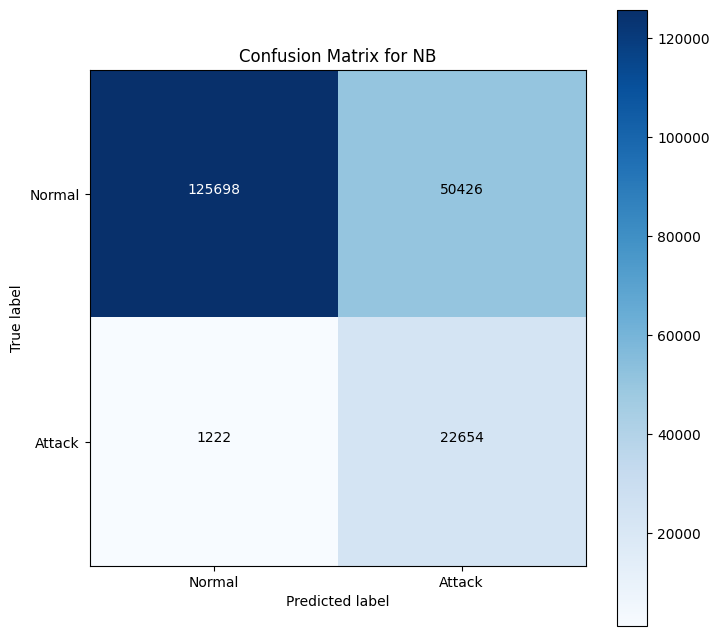

Using NB:
CIC-IDS Accuracy: 0.7418
CIC-IDS Precision: 0.3100
CIC-IDS Recall: 0.9488
CIC-IDS F1: 0.4673
CIC-IDS Miss Rate: 0.0512
CIC-IDS Training Time: 0.4157
CIC-IDS CPU Usage: 0.4000


In [17]:
from sklearn.metrics import confusion_matrix

# convert to binary
#y_pred = np.argmax(np.round(inferences), axis=1)
y_pred = np.round(inferences).astype(int)#.reshape(1,-1)
#y_pred = inferences
#y_true = np.argmax(cicids_test.y.to_numpy(), axis=1)
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for NB")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using NB:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

# On other Datasets

In [ ]:
botiot: Tuple[Dataset, Dataset] = load_data("data/sampled/botiot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
nb15: Tuple[Dataset, Dataset] = load_data("data/sampled/nb15_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
toniot: Tuple[Dataset, Dataset] = load_data("data/sampled/toniot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore

def eval_on_DT(train, test):
    model = build_decision_tree()
    start = time()
    #load1, load5, load15 = psutil.getloadavg()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit(train.X,train.y)
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_DTresults, cicids_DT = eval_on_DT(*cicids)
nb15_DTresults, nb15_DT = eval_on_DT(*nb15)
toniot_DTresults, toniot_DT = eval_on_DT(*toniot)
botiot_DTresults, botiot_DT = eval_on_DT(*botiot)

In [ ]:
def eval_on_RF(train, test):
    model = build_random_forest()
    start = time()
    #load1, load5, load15 = psutil.getloadavg()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit(train.X,train.y)
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model

cicids_RFresults, cicids_RF = eval_on_RF(*cicids)
nb15_RFresults, nb15_RF = eval_on_RF(*nb15)
toniot_RFresults, toniot_RF = eval_on_RF(*toniot)
botiot_RFresults, botiot_RF = eval_on_RF(*botiot)

In [ ]:
def eval_on_KNN(train, test):
    model = build_knn()
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit(train.X,train.y)
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model

cicids_KNNresults, cicids_KNN = eval_on_KNN(*cicids)
nb15_KNNresults, nb15_KNN = eval_on_KNN(*nb15)
toniot_KNNresults, toniot_KNN = eval_on_KNN(*toniot)
botiot_KNNresults, botiot_KNN = eval_on_KNN(*botiot)

In [ ]:
def eval_on_SVM(train, test):
    model = build_svm()
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit(train.X,train.y)
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model

cicids_SVMresults, cicids_SVM = eval_on_SVM(*cicids)
nb15_SVMresults, nb15_SVM = eval_on_SVM(*nb15)
toniot_SVMresults, toniot_SVM = eval_on_SVM(*toniot)
botiot_SVMresults, botiot_SVM = eval_on_SVM(*botiot)

In [ ]:
def eval_on_NB(train, test):
    model = build_NB()
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit(train.X,train.y)
    training_time_ = time()-start 
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_NBresults, cicids_NB = eval_on_NB(*cicids)
nb15_NBresults, nb15_NB = eval_on_NB(*nb15)
toniot_NBresults, toniot_NB = eval_on_NB(*toniot)
botiot_NBresults, botiot_NB = eval_on_NB(*botiot)

In [ ]:
df_results_DT: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])
df_results_RF: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])
df_results_KNN: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])
df_results_SVM: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])
df_results_NB: pd.DataFrame = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate","Training Time","CPU Usage"])

    
for dataset_DT in [
    ("CIC-IDS", cicids_DTresults), 
    ("UNSW-NB15", nb15_DTresults),
    ("ToN-IoT", toniot_DTresults),
    ("Bot-IoT", botiot_DTresults),
]:
    df_results_DT = df_results_DT.append({
        "Dataset": dataset_DT[0],
        "Accuracy": dataset_DT[1]["acc"],
        "Precision": dataset_DT[1]["prec"],
        "Recall": dataset_DT[1]["rec"],
        "F1": dataset_DT[1]["f1"],
        "Miss Rate": dataset_DT[1]["miss"],
        "Training Time": dataset_DT[1]["training time"],
        "CPU Usage": dataset_DT[1]["cpu usage"]
    }, ignore_index=True)
    
for dataset_RF in [
    ("CIC-IDS", cicids_RFresults), 
    ("UNSW-NB15", nb15_RFresults),
    ("ToN-IoT", toniot_RFresults),
    ("Bot-IoT", botiot_RFresults),
]:
    df_results_RF = df_results_RF.append({
        "Dataset": dataset_RF[0],
        "Accuracy": dataset_RF[1]["acc"],
        "Precision": dataset_RF[1]["prec"],
        "Recall": dataset_RF[1]["rec"],
        "F1": dataset_RF[1]["f1"],
        "Miss Rate": dataset_RF[1]["miss"],
        "Training Time": dataset_RF[1]["training time"],
        "CPU Usage": dataset_RF[1]["cpu usage"]
    }, ignore_index=True)
    
for dataset_KNN in [
    ("CIC-IDS", cicids_KNNresults), 
    ("UNSW-NB15", nb15_KNNresults),
    ("ToN-IoT", toniot_KNNresults),
    ("Bot-IoT", botiot_KNNresults),
]:
    df_results_KNN = df_results_KNN.append({
        "Dataset": dataset_KNN[0],
        "Accuracy": dataset_KNN[1]["acc"],
        "Precision": dataset_KNN[1]["prec"],
        "Recall": dataset_KNN[1]["rec"],
        "F1": dataset_KNN[1]["f1"],
        "Miss Rate": dataset_KNN[1]["miss"],
        "Training Time": dataset_KNN[1]["training time"],
        "CPU Usage": dataset_KNN[1]["cpu usage"]
    }, ignore_index=True)
    
for dataset_SVM in [
    ("CIC-IDS", cicids_SVMresults), 
    ("UNSW-NB15", nb15_SVMresults),
    ("ToN-IoT", toniot_SVMresults),
    ("Bot-IoT", botiot_SVMresults),
]:
    df_results_SVM = df_results_SVM.append({
        "Dataset": dataset_SVM[0],
        "Accuracy": dataset_SVM[1]["acc"],
        "Precision": dataset_SVM[1]["prec"],
        "Recall": dataset_SVM[1]["rec"],
        "F1": dataset_SVM[1]["f1"],
        "Miss Rate": dataset_SVM[1]["miss"],
        "Training Time": dataset_SVM[1]["training time"],
        "CPU Usage": dataset_SVM[1]["cpu usage"]
    }, ignore_index=True)

for dataset_NB in [
    ("CIC-IDS", cicids_NBresults), 
    ("UNSW-NB15", nb15_NBresults),
    ("ToN-IoT", toniot_NBresults),
    ("Bot-IoT", botiot_NBresults),
]:
    df_results_NB = df_results_NB.append({
        "Dataset": dataset_NB[0],
        "Accuracy": dataset_NB[1]["acc"],
        "Precision": dataset_NB[1]["prec"],
        "Recall": dataset_NB[1]["rec"],
        "F1": dataset_NB[1]["f1"],
        "Miss Rate": dataset_NB[1]["miss"],
        "Training Time": dataset_NB[1]["training time"],
        "CPU Usage": dataset_NB[1]["cpu usage"]
    }, ignore_index=True)

print("-------------Using Decision Tree----------------")
print(df_results_DT)



In [ ]:
print("-------------Using Random Forest----------------")
print(df_results_RF)

In [ ]:
print("-------------Using K-NN----------------")
print(df_results_KNN)

In [ ]:
print("-------------Using SVM----------------")
print(df_results_SVM)

In [ ]:
print("-------------Using NB----------------")
print(df_results_NB)

# Cross dataset Evaluation

In [ ]:
# Compute cross f1 score between datasets (ie, model trained on one dataset and evaluated on another)

def cross_f1_score(model, test: Dataset) -> float:
    inferences = model.predict(test.X)
    y_pred = np.round(inferences).astype(int).reshape(-1)
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    return f1

cross_comp_DT_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_DT_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_DT), 
    ("UNSW-NB15", nb15_DT),
    ("ToN-IoT", toniot_DT),
    ("Bot-IoT", botiot_DT),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_DT_df.loc[cross_comp_DT_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Decision Tree----------------")
cross_comp_DT_df

In [ ]:
cross_comp_RF_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_RF_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_RF), 
    ("UNSW-NB15", nb15_RF),
    ("ToN-IoT", toniot_RF),
    ("Bot-IoT", botiot_RF),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_RF_df.loc[cross_comp_RF_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Random Forest----------------")
cross_comp_RF_df

In [ ]:
cross_comp_KNN_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_KNN_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_KNN), 
    ("UNSW-NB15", nb15_KNN),
    ("ToN-IoT", toniot_KNN),
    ("Bot-IoT", botiot_KNN),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_KNN_df.loc[cross_comp_KNN_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using K-NN----------------")
cross_comp_KNN_df

In [ ]:
cross_comp_SVM_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_SVM_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_SVM), 
    ("UNSW-NB15", nb15_SVM),
    ("ToN-IoT", toniot_SVM),
    ("Bot-IoT", botiot_SVM),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_SVM_df.loc[cross_comp_SVM_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using SVM----------------")
cross_comp_SVM_df

In [ ]:
cross_comp_NB_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_NB_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_NB), 
    ("UNSW-NB15", nb15_NB),
    ("ToN-IoT", toniot_NB),
    ("Bot-IoT", botiot_NB),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_NB_df.loc[cross_comp_KNN_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using NB----------------")
cross_comp_NB_df